# Home 4: Build a CNN for image recognition.

### Name: John Cinquegrana


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM4/HM4.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

# GPU On Colab
I used Google Colab to run this code, the following excerpt checks to make sure that the GPU acceleration Colab offers is operating correctly

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!pip install keras-tuner

Found GPU at: /device:GPU:0
     |████████████████████████████████| 71kB 5.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=9ee352c95a9d120f34940283413aee72aedbac25fe3c8e6c8d5242779d2a9ba4
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=36ed1a833c698175d67ea20a213f9a336b7503b07bde52be39bdddb9b3b40f22
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


# 1. Data preparation

### 1.1. Load data


In [ ]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

170500096/170498071 [==============================] - 4s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [ ]:
def to_one_hot(y, num_class=10):
    # Function was too complicated to hold in lambda expression
    def to_one_array(num):
        ls = numpy.zeros(num_class)
        ls[num] = 1
        return ls
    # Map function over y_train vector
    return numpy.asarray( list(
        map( to_one_array, y )
    ))

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


Before we randomly partition the training and validation sets, We apply normalization to all of them

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Just to make sure we create a simple summary of the data
print("Train Maximum: {}".format( numpy.amax( x_train ) ) )
print("Train Minimum: {}".format( numpy.amin( x_train ) ) )
print("Test Maximum: {}".format( numpy.amax( x_test ) ) )
print("Test Maximum: {}".format( numpy.amin( x_test ) ) )

Train Maximum: 1.0
Train Minimum: 0.0
Test Maximum: 1.0
Test Maximum: 0.0


In [ ]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

# Set up for the CNN

My CNN is based off of the structure known as DenseNet. DenseNet acts much like ResNet using skips over layers to deal with the vanishing gradient problem, but has been known to be better with so-called *global details*. Since the CIFAR10 Database is basically a test of object recognition (since each class is defined by the object within), I though that a DenseNet would be good for this problem.

## Import Statements
Within my code I obviously use both Keras and Tensorflow. I import different convolutional layers from Keras in order to use them effectively.

If I get around to it I will also import modules from the kerastuners package in order to properly tune my hyperparameters.

In [ ]:
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, GlobalAveragePooling2D, Input, AveragePooling2D, Concatenate, Dropout
from math import floor

print( "Import statements loaded" )

Import statements loaded


## Dense Layer operations
We create a function *layers* the generate and return a set of layers used within dense blocks. This will later be used by the a dense block generating function. These layers are only used inside the dense blocks, this is basically one *step* of the algorithm inside of the dense blocks

In [ ]:
def bt_layers( left_input, number_filters, drop_rate ):
  lay = BatchNormalization()( left_input )
  lay = Activation( 'relu' )( lay )
  lay = Conv2D( 4*number_filters, (1,1), padding='same', kernel_initializer='he_normal' )( lay )
  lay = Dropout( drop_rate )( lay )
  lay = BatchNormalization() ( lay )
  lay = Activation('relu')( lay )
  lay = Conv2D( number_filters, (3,3), padding='same', kernel_initializer='he_normal' )( lay )
  lay = Dropout( drop_rate )( lay )
  return lay

## Dense Block
Here we make use of the function `dense_layers` as detailed above. We iteratively call this function and concatenate the result of previous layers in what is known as a *concatenation skip* or a *dense skip*. This is in contrast to the popular *add skip* used in the ResNet framework

In [ ]:
def make_dense_block( input, number_layers, growth_rate, drop_rate ):
  for iter in range(number_layers):
    next_output = bt_layers( input, growth_rate, drop_rate )
    input = Concatenate()([next_output, input])
  return input

## Transition Layers
These layers are occur in between each Dense Block of code. Their main function is to perform downsampling and regularization. It is at this point that many DenseNets make use of the compression parameter $\theta$ as describe in the original research paper.

In [ ]:
# Transition Layers
def trans_layers( input, theta, drop_rate ):
  lay = BatchNormalization()( input )
  number_filters = floor( theta * input.shape[-1] )

  lay = Conv2D( number_filters, (1,1), padding='same', kernel_initializer='he_normal')( lay )
  lay = Dropout( drop_rate )( lay )
  lay = AveragePooling2D()( lay ) #Pooling defaults to 2
  return lay


## Parameters
Define global values that will be used throughout the model

In [ ]:
# Simple Problem Definitions
batch_size = 32 #I don't consider this a hyperparameter since it's solely based off GPU availability
num_classes = 10
epochs = 30
hp_epochs = 16
image_shape = x_tr.shape[1:]
initial_learning_rate = 1e-3 #I don't change the learning rate, because of the scheduler and reducer


print( "Batch Size: {}".format(batch_size) )
print( "Epochs: {}".format(epochs) )
print( "The HyperParameters will be tuned over a max of {} epochs.".format(hp_epochs))
print( "Our CNN will work with the shape {}".format( image_shape ) )

Batch Size: 32
Epochs: 30
The HyperParameters will be tuned over a max of 16 epochs.
Our CNN will work with the shape (32, 32, 3)


# The Fun Part
We use the parameters we have just defined to build the densenet model.

## Build Model Function
Because we're using keras-tuners to tune the hyperparameters, we need a `build_model` function. keras-tuners will take this function and optimize all the hyperparameters we take out of it to be the best.
The build_model function returns a full DenseNet CNN when it is called.

In [ ]:
from keras.models import Model

def build_model(HP):
  theta = HP.Float('theta', 0.2, 0.6, step=0.1)
  growth_rate = HP.Int('growth_rate', 8, 20, step=2)
  bottleneck_layers = HP.Int('bottleneck_layers', 12, 20, step=2)
  dense_blocks = HP.Int('dense_blocks', 2, 4)
  drop_rate = HP.Float('drop_rate', 0.1, 0.5)
  initial_filters = growth_rate*2

  # This initial layers that will deal with the input
  initial_layer = Input( shape=image_shape )
  layers = BatchNormalization()( initial_layer )
  layers = Activation( 'relu' )( layers )
  layers = Conv2D( initial_filters, (3,3), padding='same', kernel_initializer='he_normal' )( layers )
  layers = Concatenate()([initial_layer, layers])

  # Create the Dense Blocks
  for _ in range( dense_blocks ):
    layers = make_dense_block(layers, bottleneck_layers, growth_rate, drop_rate)
    layers = trans_layers( layers, theta, drop_rate )

  # The final layers of the CNN
  layers = GlobalAveragePooling2D()( layers )
  layers = Dense( num_classes )( layers )
  final_layer = Activation( 'softmax' )( layers )

  model = Model(initial_layer, final_layer)
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.RMSprop( learning_rate=initial_learning_rate ), #I've been told RMSProp works well for DenseNets
                metrics=['accuracy'])
  return model

## Generate callbacks
The Callbacks of a keras model are called every single Epoch. I use them to schedule/change the learning rate, and to stop early and ease computation drain.

In [ ]:
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

def gen_callbacks(inital_lr, early_delta=0.01):
  reducer = ReduceLROnPlateau(factor=0.3,
                            cooldown=0,
                            verbose=1, #Give us update messages
                            patience=4,
                            min_lr=0.5e-6
                            )

  def schedule(epoch, cur_lr):
      lr = inital_lr
      if epoch > (epochs*0.9):
          lr *= 0.5e-2
      elif epoch > (epochs*0.8):
          lr *= 1e-2
      elif epoch > (epochs*0.6):
          lr *= 1e-1
      elif epoch > (epochs*0.4):
          lr *= 0.5
      result = min(lr, cur_lr)
      print('Learning rate: ', result)
      return result

  scheduler = LearningRateScheduler(schedule)

  early_stop = EarlyStopping(min_delta=early_delta, patience=3, verbose=0,
    mode='min')

  return [scheduler, reducer, early_stop]

## Data Augmentation
We perform data augmentation by using Keras's built in ImageGenerator. The Generator will randomly change data being sent into the neural net to help reduce overfitting and pseudo-increase the sample size.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit( x_tr )

## Train HyperParameters with KerasTuner
Using KerasTuner we train all the hyperparameters using the HyperBand search algorithm

In [ ]:
# Train the HyperParameters with KerasTuner

import kerastuner as kt
from kerastuner.tuners import Hyperband

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=hp_epochs)

cb = gen_callbacks( initial_learning_rate )

tuner.search(datagen.flow(x_tr, y_tr, batch_size=batch_size),
    batch_size=batch_size, verbose=1, epochs=hp_epochs, validation_data=(x_val, y_val),
    callbacks=cb)

Trial 30 Complete [00h 33m 56s]
val_accuracy: 0.8208000063896179

Best val_accuracy So Far: 0.8471999764442444
Total elapsed time: 07h 49m 59s
INFO:tensorflow:Oracle triggered exit


## Hyperparameters are set
Now that we have all the hyperparameters, let us take a look at them. Unfortunately keras-tuners doesn't allow us to look at the history of the `model.fit` results, however we can see a summary of the hyperparameter search

In [27]:
# Show the results of the tuner
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
theta: 0.30000000000000004
growth_rate: 14
bottleneck_layers: 18
dense_blocks: 3
drop_rate: 0.12530065427527037
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 6d4fb7de9a08cf658eccc8cc9c987437
Score: 0.8471999764442444
Trial summary
Hyperparameters:
theta: 0.4000000000000001
growth_rate: 10
bottleneck_layers: 12
dense_blocks: 4
drop_rate: 0.21477025247089193
tuner/epochs: 16
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8208000063896179
Trial summary
Hyperparameters:
theta: 0.30000000000000004
growth_rate: 12
bottleneck_layers: 18
dense_blocks: 3
drop_rate: 0.15310972703932527
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 21c511aa74baf0e9d9e8f9135ba3ce7a
Score: 0.8202999830245972
Trial summary
Hyperparameters:
theta: 0.6000000000000001
growth

# 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [29]:
# Get the best model that the tuner trained
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
# Warnings occur in all of the hyperparameters that were either assumed by the model, or set as static and not trained
# To my knowledge there is no way to remove the warnings
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 3)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 28)   784         activation[0][0]                 
______________________________________________________________________________________________

## Data augmentation
Create another data generator, this time acting on all of `x_train`.

In [30]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit( x_train )

## Full Training
We have everything we need to train the actual model again. the callbacks will be mostly the same, but we must generate them with a different number of epochs

In [34]:
# The number of epochs listed before would have taken too long to train, so we lower it for the actual model
epochs = 20

reducer = ReduceLROnPlateau(factor=0.3,
                            cooldown=0,
                            verbose=1, #Give us update messages
                            patience=4,
                            min_lr=0.5e-6,
                            monitor='loss'
                            )

def schedule(epoch, cur_lr):
    lr = 1e-3
    if epoch > (epochs*0.9):
        lr *= 0.5e-2
    elif epoch > (epochs*0.8):
        lr *= 1e-2
    elif epoch > (epochs*0.6):
        lr *= 1e-1
    elif epoch > (epochs*0.4):
        lr *= 0.5
    result = min(lr, cur_lr)
    print('Learning rate: ', result)
    return result

scheduler = LearningRateScheduler(schedule)

early_stop = EarlyStopping(min_delta=0.01, patience=3, verbose=0,
  mode='min', monitor='loss')

cb = [scheduler, reducer, early_stop]

history = best_model.fit(datagen.flow(x_train, y_train_vec, batch_size=batch_size),
    batch_size=batch_size, verbose=1, epochs=epochs,
    callbacks=cb)

Epoch 1/20
Learning rate:  0.001
1563/1563 [==============================] - 241s 154ms/step - loss: 0.5388 - accuracy: 0.8147
Epoch 2/20
Learning rate:  0.001
1563/1563 [==============================] - 242s 155ms/step - loss: 0.5004 - accuracy: 0.8270
Epoch 3/20
Learning rate:  0.001
1563/1563 [==============================] - 241s 154ms/step - loss: 0.4743 - accuracy: 0.8378
Epoch 4/20
Learning rate:  0.001
1563/1563 [==============================] - 242s 155ms/step - loss: 0.4448 - accuracy: 0.8476
Epoch 5/20
Learning rate:  0.001
1563/1563 [==============================] - 242s 155ms/step - loss: 0.4253 - accuracy: 0.8529
Epoch 6/20
Learning rate:  0.001
1563/1563 [==============================] - 241s 154ms/step - loss: 0.4042 - accuracy: 0.8608
Epoch 7/20
Learning rate:  0.001
1563/1563 [==============================] - 242s 155ms/step - loss: 0.3852 - accuracy: 0.8676
Epoch 8/20
Learning rate:  0.001
1563/1563 [==============================] - 242s 155ms/step - loss: 0.

Note that an early stopping callback is used. If you run this model yourself, espeically with a higher epoch value, it's very possible your model may stop training before the final epoch value is hit. This is normal.

## A Test Accuracy Above 90%!!
Quite honestly I spent a lot of time researching new models, and training this took up around 9 hours of my day. I am quite proud of how the model performed, and I am so excited to have broken the 90% barrier.

## History
Let's create a nifty little graph showing the history of the model

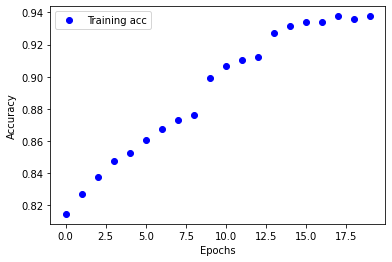

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [36]:
loss_and_acc = best_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 12s 30ms/step - loss: 0.2939 - accuracy: 0.9144
loss = 0.2938983142375946
accuracy = 0.9143999814987183


## Final Results

We reached an accuracy of `93.77` on the testing set and an accuracy of `91.44` on the training set. I do suspect there is some amount of overfitting occuring despite my attempts to combat it.   
Overall I believe the accuracy is quite high; while a better network can obviously be made, the DenseNet structure seemed quite suited to the 10-class classification task.